In [4]:
pip install pyocclient

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for pyocclient: filename=pyocclient-0.6-py3-none-any.whl size=26080 sha256=404760e48119f8c99174b6329a2e5df9fe83ea8879841b5ef315848d597f6824
  Stored in directory: /tmp/pip-ephem-wheel-cache-g1qzmg_l/wheels/79/c2/ab/1835c43b138eb68a870c744df40ce83e1466bea76898b3a943
Successfully built pyocclient
Note: you may need to restart the kernel to use updated packages.


In [2]:
import owncloud


In [2]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
# Import dependencies
import os
import numpy as np
from matplotlib import pyplot as plt

import skimage.io as skio

## Basics of image (pre)processing

/tmp/ipykernel_482/3479303637.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(image)


(np.float64(-0.5), np.float64(1349.5), np.float64(1484.5), np.float64(-0.5))

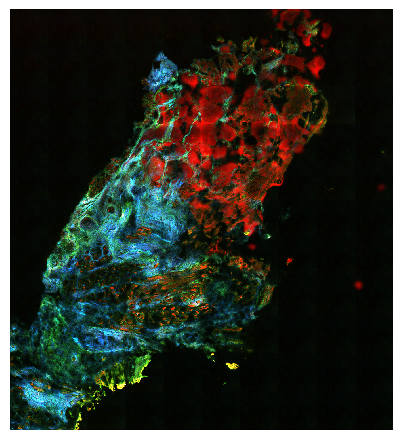

In [4]:
image = skio.imread('./data/example_image.png')

skio.imshow(image)
plt.axis('off')

In [9]:
### Normalization: important for modeling, depending on the model being used
# transform from 0~255 to 0~1
image_0_1 = image / 255.
print("Range normalizated image  : ", np.min(image_0_1), np.max(image_0_1))

# transform from 0~255 to -1~1
image_neg1_1 = (image - 127.5) / 127.5
print("Range normalizated image  : ", np.min(image_neg1_1), np.max(image_neg1_1))

Range normalizated image  :  0.0 1.0
Range normalizated image  :  -1.0 1.0


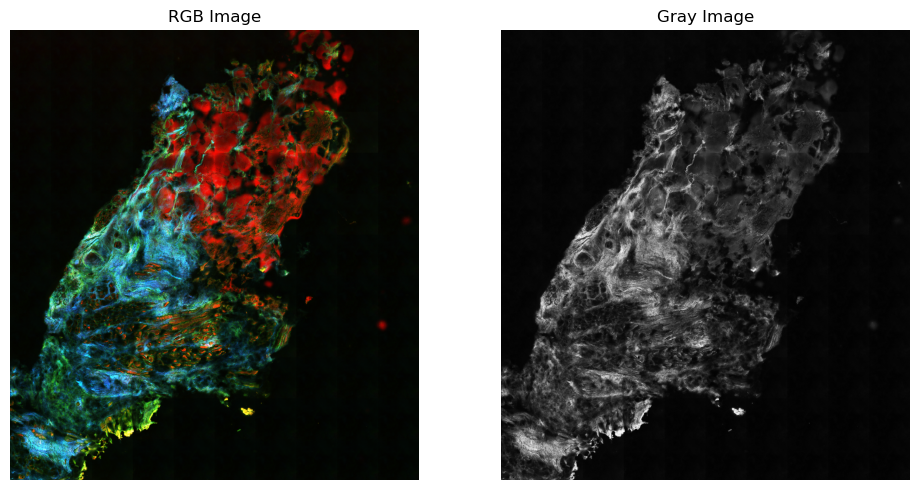

In [30]:
### Convert RGB into gray-level image
from skimage.color import rgb2gray
image_gray = rgb2gray(image)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('RGB Image')

ax[1].imshow(image_gray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Gray Image')
plt.tight_layout()
plt.show()

### Alternatively, use `Gray = a * R + b * G + c * B`

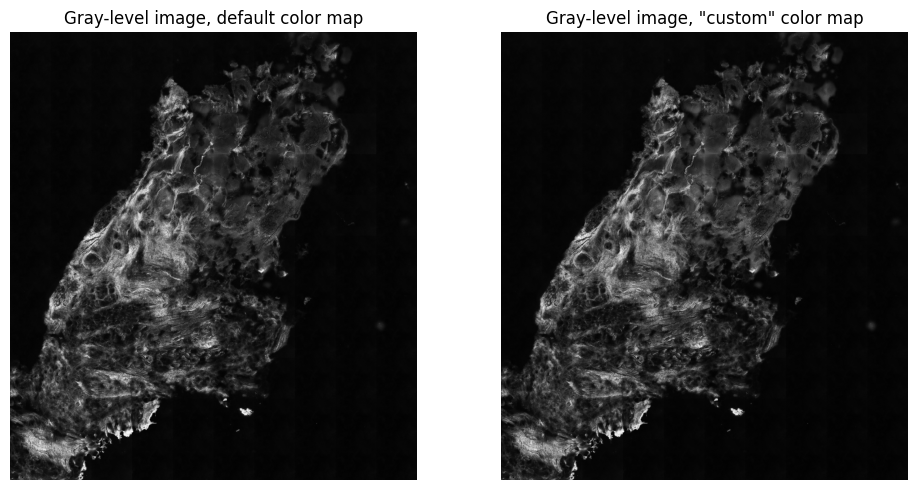

In [38]:
# Directly 
a = 0.2989
b = 0.5870
c = 1- (a+b)
image_gray1 = a * image[:,:,0] + b* image[:,:,1]+ c* image[:,:,2]

# Plot figures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title("Gray-level image, default color map")
ax[0].axis('off')

ax[1].imshow(image_gray1, cmap="gray")
ax[1].set_title("Gray-level image, \"custom\" color map")
ax[1].axis('off')
plt.tight_layout()
plt.show()

### crop image

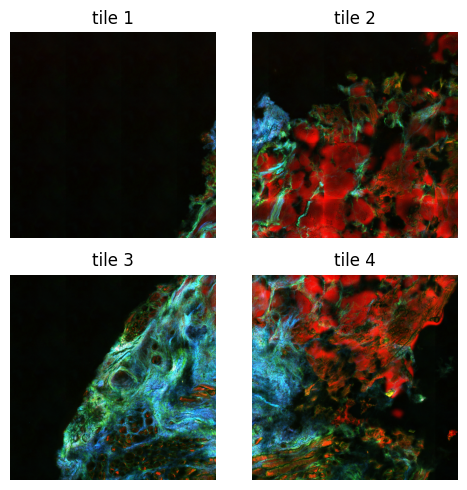

In [39]:
# Directly 
img_tile_1 = image[:500, :500, :]
img_tile_2 = image[:500, 500:1000, :]
img_tile_3 = image[500:1000, :500, :]
img_tile_4 = image[500:1000, 500:1000, :]

# Plot figures
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(img_tile_1)
ax[0, 0].set_title("tile 1")
ax[0, 0].axis("off")

ax[0, 1].imshow(img_tile_2)
ax[0, 1].set_title("tile 2")
ax[0, 1].axis("off")

ax[1, 0].imshow(img_tile_3)
ax[1, 0].set_title("tile 3")
ax[1, 0].axis("off")

ax[1, 1].imshow(img_tile_4)
ax[1, 1].set_title("tile 4")
ax[1, 1].axis("off")

plt.tight_layout()    
plt.show()

### change value of certain pixel positions

Useful to mark some areas, helpful to achieve certain aims of modelling, e.g., robustness, self-supervised learning

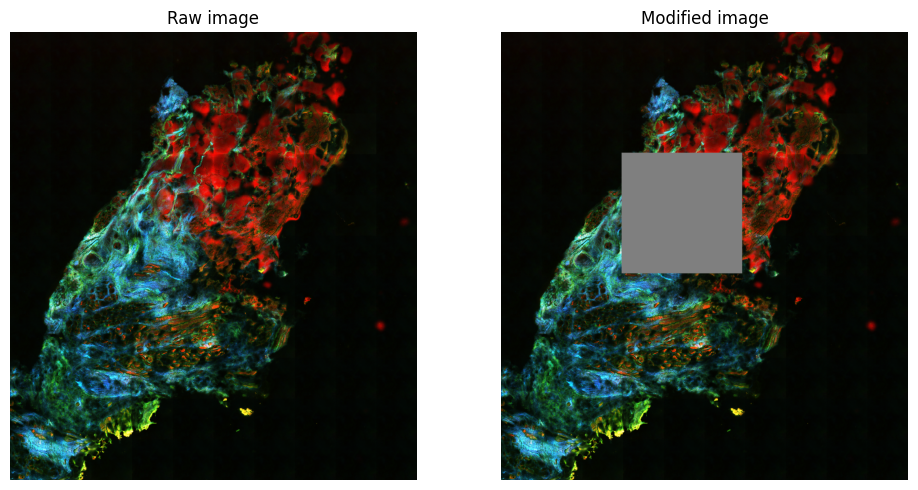

In [40]:
# Set some values to [0, 255, 0] (green)
image_change = image.copy()

image_change[400:800, 400:800] = [127., 127., 127]

# Plot figures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Raw image")
ax[0].axis('off')

ax[1].imshow(image_change, cmap="gray")
ax[1].set_title("Modified image")
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Rescale resize image

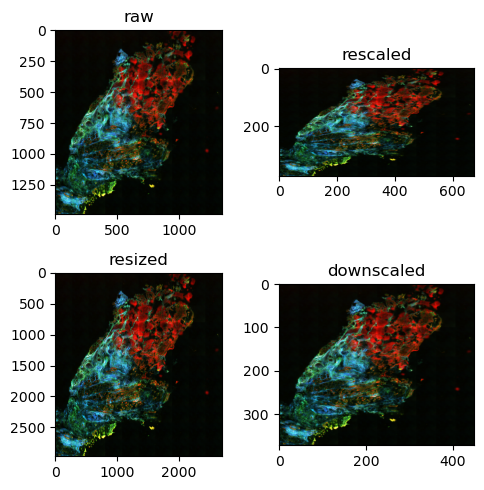

In [58]:
from skimage.transform import rescale, resize, downscale_local_mean

image_rescaled = rescale(image, (0.25, 0.5, 1), anti_aliasing=False)  ## interpolatation

image_resized = resize(image, (image.shape[0] *2, image.shape[1] *2), anti_aliasing=True)   ## interpolatation

image_downscaled = downscale_local_mean(image, factors=(4, 3, 1))   ### downscale by local average

# Plot figures
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(image)
ax[0, 0].set_title("raw")

ax[0, 1].imshow(image_rescaled)
ax[0, 1].set_title("rescaled")

ax[1, 0].imshow(image_resized)
ax[1, 0].set_title("resized")

ax[1, 1].imshow(image_downscaled/255.0)
ax[1, 1].set_title("downscaled")

plt.tight_layout()    
plt.show()

## Deep learning for image analysis

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import img_to_array, array_to_img

2025-08-28 08:09:36.802883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756368576.812364     686 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756368576.815123     686 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 08:09:36.826822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Select GPU and allow memory growth

```set_memory_growth = True``` allows for dynamic GPU memory allocation

In [60]:
# Select GPU we want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [62]:
# Set up mixed precision policies
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Get cifar10 dataset from keras

This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. 

<table>
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>airplane</td>
</tr>
<tr>
<td align="center">1</td>
<td>car</td>
</tr>
<tr>
<td align="center">2</td>
<td>bird</td>
</tr>
<tr>
<td align="center">3</td>
<td>cat</td>
</tr>
<tr>
<td align="center">4</td>
<td>deer</td>
</tr>
<tr>
<td align="center">5</td>
<td>dog</td>
</tr>
<tr>
<td align="center">6</td>
<td>frog</td>
</tr>
<tr>
<td align="center">7</td>
<td>horse</td>
</tr>
<tr>
<td align="center">8</td>
<td>ship</td>
</tr>
<tr>
<td align="center">9</td>
<td>truck</td>
</tr>
</tbody>
</table>

In [63]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# we check the dataset shape
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 


In [56]:
# Dictionary containg the sematic classes
label_dict = {0:"airplane", 1:"car", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

In [57]:
### choose part of the image to reduce calculation time
ids = np.random.randint(1, 50000, size=5000)
x_train, y_train = x_train[ids], y_train[ids]

ids = np.random.randint(1, 10000, size=1000)
x_test, y_test = x_test[ids], y_test[ids]

In [58]:
x_train = x_train/255.
x_test = x_test/255.

### Shuffle and make mini-batches

`buffer_size` determines the number of elements from which the new shuffled dataset will draw. Larger buffer sizes provide better shuffling but require more memory.

In [16]:
# # define batch size (number of samples training for iteration)
# BATCH_SIZE = 128

# # define size of the buffer to shuffle the data (optional)
# SHUFFLE_BUFFER_SIZE = 1000

# # shufle data and set batch size
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

In [51]:
### Define a neural network
def gen_model(input_size, output_size):
    
    model = tf.keras.Sequential([
            keras.Input(shape=input_size),   # set input shape
        
            keras.layers.Conv2D(64, 3, activation='relu'),      # include 2D convolutions, conv2d(n_kernels, size)
            keras.layers.Conv2D(64, 3, activation='relu'),
            keras.layers.Conv2D(64, 3, activation='relu'),
        
            keras.layers.Flatten(),          # reshape to 1D vector
        
            keras.layers.Dense(256, activation='relu'),  # Dense layer with 256 outputs, no linear activation
            keras.layers.Dense(output_size, activation='softmax')  # output layer with 10 outputs
        ])
    return model

In [60]:
input_size = (32, 32, 3)
output_size = 10
learning_rate = 0.0001

model = gen_model(input_size, output_size)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [61]:
path_h5 = "shallowNet.weights.h5"
checkpointer = ModelCheckpoint(path_h5, verbose=0, save_freq="epoch", save_weights_only=True)   ### save model weights at certan frequency
history = model.fit(x_train, y_train, 
                    batch_size=16,
                    epochs=20,
                    verbose=1,     # 0-no output, 1-progress bar, 2-one line per epoch
                    validation_data=None,
                    validation_split=0.2,
                    callbacks=[checkpointer],
                    shuffle=True
                    )

Epoch 1/20
250/250 [==============================] - 3s 9ms/step - loss: 1.9581 - sparse_categorical_accuracy: 0.2873 - val_loss: 1.8046 - val_sparse_categorical_accuracy: 0.3550
Epoch 2/20
250/250 [==============================] - 2s 6ms/step - loss: 1.6016 - sparse_categorical_accuracy: 0.4268 - val_loss: 1.6304 - val_sparse_categorical_accuracy: 0.4110
Epoch 3/20
250/250 [==============================] - 1s 6ms/step - loss: 1.4440 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.6082 - val_sparse_categorical_accuracy: 0.4360
Epoch 4/20
250/250 [==============================] - 1s 6ms/step - loss: 1.2734 - sparse_categorical_accuracy: 0.5480 - val_loss: 1.5537 - val_sparse_categorical_accuracy: 0.4560
Epoch 5/20
250/250 [==============================] - 1s 6ms/step - loss: 1.1295 - sparse_categorical_accuracy: 0.5947 - val_loss: 1.5280 - val_sparse_categorical_accuracy: 0.4820
Epoch 6/20
250/250 [==============================] - 2s 6ms/step - loss: 0.9840 - sparse_categorica

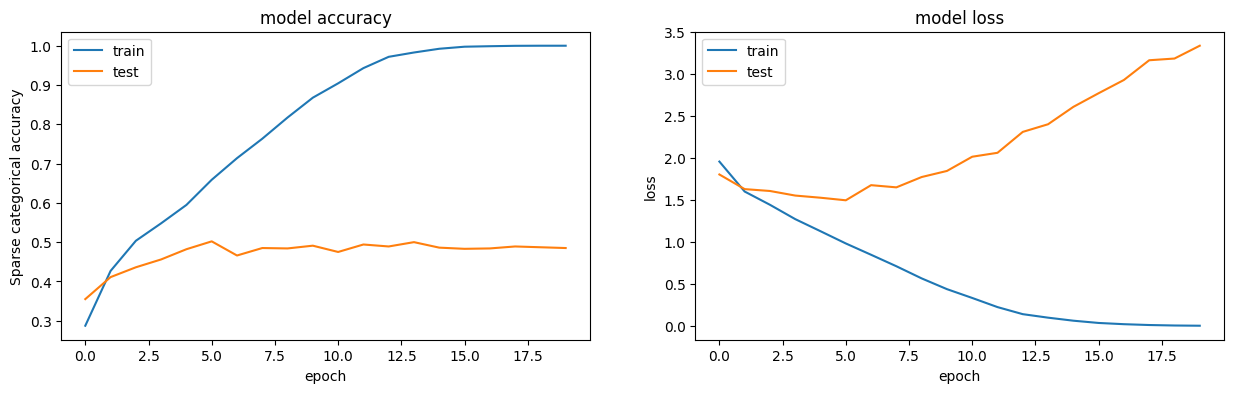

In [62]:
### plot history
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# summarize history for accuracy
ax[0].plot(history.history['sparse_categorical_accuracy'])
ax[0].plot(history.history['val_sparse_categorical_accuracy'])
ax[0].set(title='model accuracy', ylabel = 'Sparse categorical accuracy', xlabel='epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set(title='model loss', ylabel='loss', xlabel= 'epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

32/32 [==============================] - 0s 4ms/step
prediction shape :  (1000, 10)
prediction_class shape (1000,)


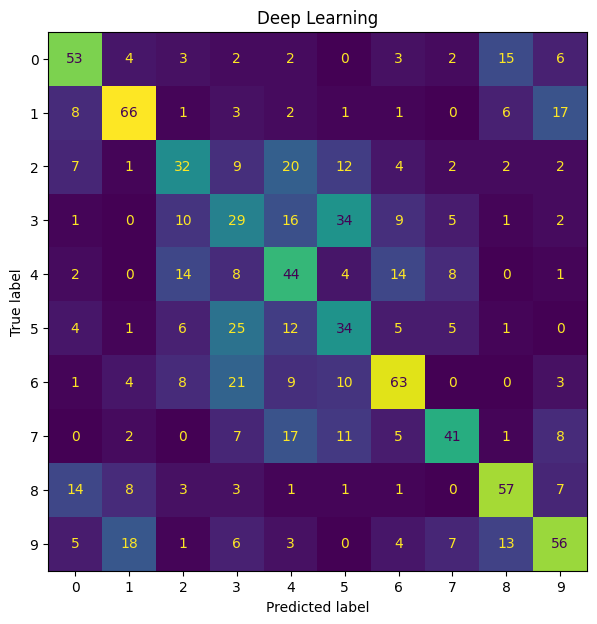

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

prediction = model.predict(x_test)
print("prediction shape : ", np.shape(prediction))

prediction_class = np.argmax(prediction, axis=-1)
print("prediction_class shape", np.shape(prediction_class))

cmat_DL = confusion_matrix(y_test, prediction_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat_DL, display_labels=np.unique(y_train))
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
disp.plot(ax=ax, colorbar=False)
plt.title('Deep Learning')
plt.show()


In [64]:
balanced_accuracy_score(y_test, prediction_class)

0.4739525158936015

### Augmentation

In [65]:
### Define a neural network

from tensorflow.keras.layers.experimental import preprocessing

def gen_model_aug(input_size, output_size):
    
    model = tf.keras.Sequential([
            keras.Input(shape=input_size),   # set input shape
        
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.2),
        
            keras.layers.Conv2D(64, 3),      # include 2D convolutions, conv2d(n_kernels, size)
            keras.layers.Conv2D(64, 3),
            keras.layers.Conv2D(64, 3),
        
            keras.layers.Flatten(),          # reshape to 1D vector
        
            keras.layers.Dense(256, activation='relu'),  # Dense layer with 256 outputs, no linear activation
            keras.layers.Dense(output_size, activation='softmax')  # output layer with 10 outputs
        ])
    return model

In [66]:
input_size = (32, 32, 3)
output_size = 10
learning_rate = 0.0001

model_aug = gen_model_aug(input_size, output_size)
model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])

In [67]:
path_h5 = "shallowNet_aug.weights.h5"
checkpointer = ModelCheckpoint(path_h5, verbose=0, save_freq="epoch")   ### save model weights at certan frequency
history = model_aug.fit(x_train, y_train, 
                        batch_size=None,
                        epochs=20,
                        verbose=2,     # 0-no output, 1-progress bar, 2-one line per epoch
                        validation_data=None,
                        validation_split=0.2,
                        callbacks=[checkpointer],
                        shuffle=True
                        )

Epoch 1/20
125/125 - 18s - loss: 2.0730 - sparse_categorical_accuracy: 0.2453 - val_loss: 1.9501 - val_sparse_categorical_accuracy: 0.2920 - 18s/epoch - 143ms/step
Epoch 2/20
125/125 - 14s - loss: 1.8964 - sparse_categorical_accuracy: 0.3237 - val_loss: 1.8842 - val_sparse_categorical_accuracy: 0.3240 - 14s/epoch - 114ms/step
Epoch 3/20
125/125 - 14s - loss: 1.8093 - sparse_categorical_accuracy: 0.3498 - val_loss: 1.8269 - val_sparse_categorical_accuracy: 0.3720 - 14s/epoch - 115ms/step
Epoch 4/20
125/125 - 14s - loss: 1.7728 - sparse_categorical_accuracy: 0.3587 - val_loss: 1.8186 - val_sparse_categorical_accuracy: 0.3740 - 14s/epoch - 115ms/step
Epoch 5/20
125/125 - 14s - loss: 1.7225 - sparse_categorical_accuracy: 0.3885 - val_loss: 1.8111 - val_sparse_categorical_accuracy: 0.3680 - 14s/epoch - 116ms/step
Epoch 6/20
125/125 - 14s - loss: 1.6864 - sparse_categorical_accuracy: 0.3875 - val_loss: 1.7667 - val_sparse_categorical_accuracy: 0.3970 - 14s/epoch - 113ms/step
Epoch 7/20
125/1

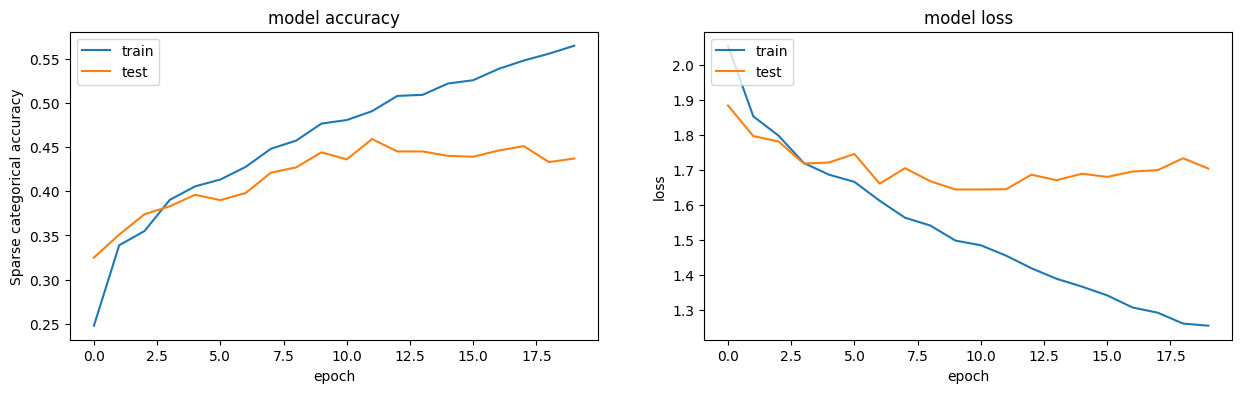

In [25]:
### plot history
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# summarize history for accuracy
ax[0].plot(history.history['sparse_categorical_accuracy'])
ax[0].plot(history.history['val_sparse_categorical_accuracy'])
ax[0].set(title='model accuracy', ylabel = 'Sparse categorical accuracy', xlabel='epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set(title='model loss', ylabel='loss', xlabel= 'epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.show()

32/32 [==============================] - 0s 2ms/step
prediction shape :  (1000, 10)
prediction_class shape (1000,)


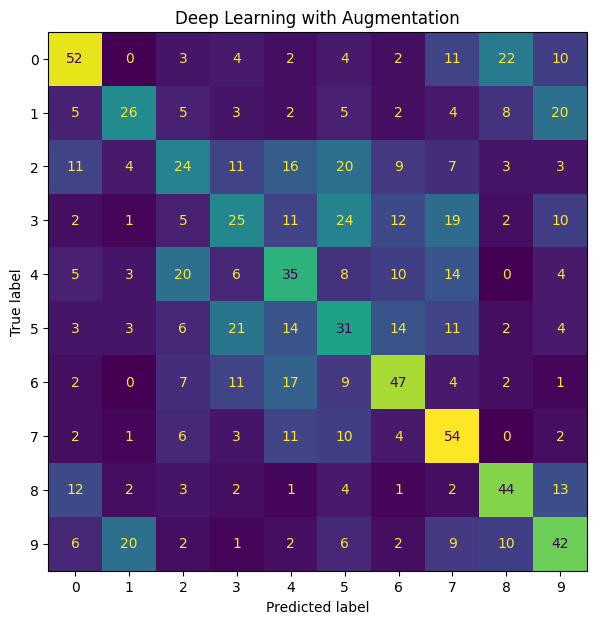

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model_aug.predict(x_test)
print("prediction shape : ", np.shape(prediction))

prediction_class = np.argmax(prediction, axis=-1)
print("prediction_class shape", np.shape(prediction_class))

cmat_DL = confusion_matrix(y_test, prediction_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat_DL, display_labels=np.unique(y_train))
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
disp.plot(ax=ax, colorbar=False)
plt.title('Deep Learning with Augmentation')
plt.show()

### full convolutional neural network (FCNN)

* flexible to image sizes
* cannot have any dense layers

In [68]:
def gen_model_fcnn(input_size, out_channel):
    
    model = tf.keras.Sequential([
            keras.Input(shape=input_size),   # set input shape
        
            keras.layers.Conv2D(16, 3, padding='same'),      # include 2D convolutions, conv2d(n_kernels, size)
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2D(8, 3, padding='same'),
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2DTranspose(8, 3, padding='same'),
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2DTranspose(16, 3, padding='same'),
            keras.layers.Activation('relu'),
            keras.layers.BatchNormalization(),
        
            keras.layers.Conv2D(out_channel, 3, padding='same'),
        ])
    return model

In [69]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [70]:
### choose part of the image to reduce calculation time
ids = np.random.randint(1, 60000, size=6000)
x_train, y_train = x_train[ids], y_train[ids]

ids = np.random.randint(1, 10000, size=1000)
x_test, y_test = x_test[ids], y_test[ids]

In [71]:
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train[:,:, :, np.newaxis]
x_test = x_train[:,:, :, np.newaxis]

In [72]:
input_size = (None, None, 1)
output_size = 10
learning_rate = 0.0001

model_fcnn = gen_model_fcnn(input_size, 1)
model_fcnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=['mean_absolute_error'])

In [73]:
model_fcnn.fit(x_train, x_train,
              batch_size=None,
              epochs=20,
              verbose=1,     # 0-no output, 1-progress bar, 2-one line per epoch
              validation_data=None,
              validation_split=0.2,
              callbacks=None,
              shuffle=True)

Epoch 1/20
150/150 [==============================] - 2s 10ms/step - loss: 0.5320 - mean_absolute_error: 0.5320 - val_loss: 0.2169 - val_mean_absolute_error: 0.2169
Epoch 2/20
150/150 [==============================] - 1s 7ms/step - loss: 0.2752 - mean_absolute_error: 0.2752 - val_loss: 0.2405 - val_mean_absolute_error: 0.2405
Epoch 3/20
150/150 [==============================] - 1s 7ms/step - loss: 0.1803 - mean_absolute_error: 0.1803 - val_loss: 0.1764 - val_mean_absolute_error: 0.1764
Epoch 4/20
150/150 [==============================] - 1s 7ms/step - loss: 0.1333 - mean_absolute_error: 0.1333 - val_loss: 0.1221 - val_mean_absolute_error: 0.1220
Epoch 5/20
150/150 [==============================] - 1s 7ms/step - loss: 0.1063 - mean_absolute_error: 0.1063 - val_loss: 0.1000 - val_mean_absolute_error: 0.1000
Epoch 6/20
150/150 [==============================] - 1s 7ms/step - loss: 0.0882 - mean_absolute_error: 0.0882 - val_loss: 0.0851 - val_mean_absolute_error: 0.0851
Epoch 7/20
150/

1/1 [==============================] - 0s 121ms/step


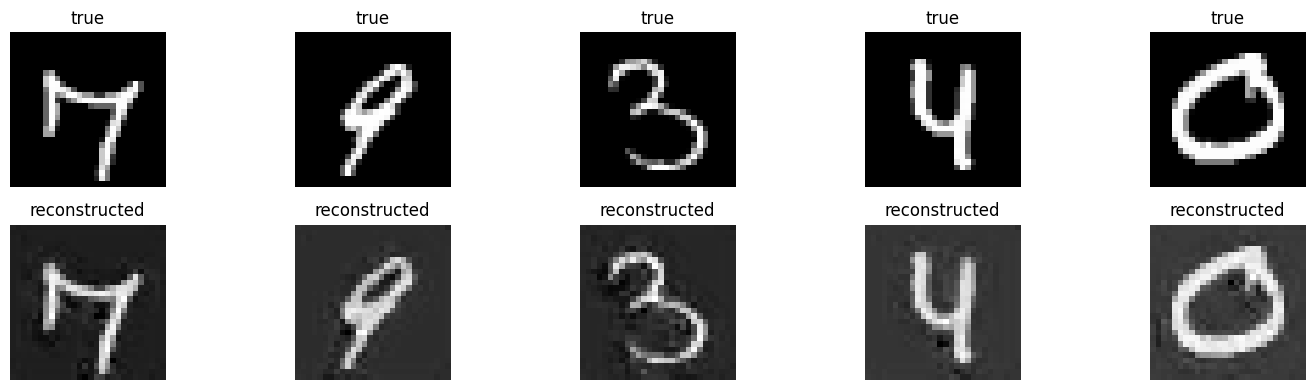

In [74]:
pred_test = model_fcnn.predict(x_test[0:5])
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 4))

for i in range(5):
    
    # summarize history for accuracy
    ax[0, i].imshow(x_test[i, :, :, 0], cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title('true')
    
    ax[1, i].imshow(pred_test[i, :, :, 0], cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title('reconstructed')
    
plt.tight_layout()
plt.show()